# Emotions 

Esse Jupyter Notebook apresenta nosso estudo e os resultados obtidos para o conjunto de dados *Emotions*.

In [1]:
# Instalação dos pacotes
# !pip install --upgrade pip
# !pip install scikit-multilearn
# !pip install scipy
# !pip install pandas
# !pip install matplotlib
# !pip install numpy
# !pip install -U scikit-learn

## Leitura dos dados e Pré-processamento

A função convert é responsável por transformar dados categóricos e binários para dados numéricos.

In [2]:
def convert(a):
    # tenta converter para uma string
    try:
        b = a.decode("utf-8")
    except:
        # eh um numero
        return a
    # tenta converter para um inteiro
    try:
        return int(b)
    except:
        # eh um atributo nominal
        if b == 'YES':
            return 1
        if b == 'NO':
            return 0
        return b

In [19]:
# Imports necessários para extraçao dos dados
import scipy
from scipy.io import arff
import pandas as pd

# Carregando o treino
data_train, meta_train = scipy.io.arff.loadarff(f'datasets/emotions/emotions-train.arff')
X_train = pd.DataFrame(data_train)

# Carregando o teste
data_test, meta_test = scipy.io.arff.loadarff(f'datasets/emotions/emotions-test.arff')
X_test = pd.DataFrame(data_test)

# Pré-processamento
# Transformando em atributos numéricos
X_test = X_test.applymap(convert)
X_train = X_train.applymap(convert)



# # Separando o Y do treino
Y_train = X_train.iloc[:, -72:]
X_train.drop(columns=list(Y_train.columns), inplace=True)

# # Separando o Y do teste
Y_test = X_test.iloc[:, -72:]
X_test.drop(columns=list(Y_test.columns), inplace=True)


print(Y_test)

     Mean_Acc1298_Mean_Mem40_Centroid  Mean_Acc1298_Mean_Mem40_Rolloff  \
0                            0.036299                         0.064986   
1                            0.161218                         0.467820   
2                            0.115987                         0.336879   
3                            0.086016                         0.141845   
4                            0.063232                         0.140621   
..                                ...                              ...   
197                          0.027142                         0.047551   
198                          0.094829                         0.204498   
199                          0.035169                         0.065403   
200                          0.054276                         0.238158   
201                          0.073194                         0.140733   

     Mean_Acc1298_Mean_Mem40_Flux  Mean_Acc1298_Mean_Mem40_MFCC_0  \
0                        0.082104         

In [16]:
# Verificando se o pré-processamento foi bem sucedida nos rótulos.
Y_test

,Mean_Acc1298_Mean_Mem40_MFCC_3,Mean_Acc1298_Mean_Mem40_MFCC_4,Mean_Acc1298_Mean_Mem40_MFCC_5,Mean_Acc1298_Mean_Mem40_MFCC_6,Mean_Acc1298_Mean_Mem40_MFCC_7,Mean_Acc1298_Mean_Mem40_MFCC_8,Mean_Acc1298_Mean_Mem40_MFCC_9,Mean_Acc1298_Mean_Mem40_MFCC_10,Mean_Acc1298_Mean_Mem40_MFCC_11,Mean_Acc1298_Mean_Mem40_MFCC_12,...,BH_HighLowRatio,BHSUM1,BHSUM2,BHSUM3,amazed-suprised,happy-pleased,relaxing-calm,quiet-still,sad-lonely,angry-aggresive
0,2.546373,0.671063,1.589821,0.576485,0.089158,0.261224,0.167199,0.661612,0.139440,0.453410,...,2.0,0.095982,0.520006,0.677943,0,0,1,1,1,0
1,1.097346,0.641059,0.372797,0.991050,0.398497,0.620176,0.640384,0.371496,0.771620,0.377546,...,2.0,0.752210,0.576382,1.477141,1,0,0,0,0,1
2,1.792451,0.611347,0.287022,0.772846,0.858681,0.516220,0.953049,0.462743,0.278748,0.692991,...,2.0,0.488375,0.004603,1.147727,0,0,0,0,1,0
3,1.326248,0.340032,1.290664,0.337209,0.156768,0.419102,0.817250,0.485674,0.346063,0.314718,...,2.0,0.430059,0.102757,1.276632,0,1,1,0,0,0
4,1.023655,0.439544,0.855564,0.414784,0.086249,0.316512,0.758706,0.556832,0.436872,0.649256,...,2.0,1.788567,0.032760,3.076057,0,0,0,0,1,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
197,1.696017,0.397888,0.857559,0.302742,0.672649,0.748163,0.412952,0.852625,0.597127,0.456126,...,2.0,0.261742,0.002657,1.149211,0,0,1,1,1,0
198,1.440352,0.856243,1.110282,0.394450,0.726323,0.885339,0.517613,-0.186371,0.531083,0.312116,...,2.0,0.282122,0.052218,0.335371,1,0,0,0,1,1
199,0.818851,1.569606,1.831909,0.057216,0.419342,0.482342,0.745151,0.403275,0.838195,0.711755,...,2.0,0.184313,0.247136,0.476993,0,0,1,1,1,0
200,2.407780,0.618838,0.997950,0.825143,0.758816,0.727540,0.500074,0.402084,0.539242,0.326410,...,2.0,0.547126,0.183494,1.255820,0,1,1,0,0,0


## Algoritmos
Vamos estudar esse conjunto de dados com três métodos de classificação multirrótulo:
- Binary Relevance
- Classifier Chains
- Label Powersets.

Também utilizamos três classificadores de um rótulo para cada classificador multirrótulo, são eles:
- Multinomial Naive Bayes
- Decision Tree Classifier
- Random Forest Classifier. 



### Binary Relevance

In [17]:
# Começamos com o Binary Relevance
from skmultilearn.problem_transform import BinaryRelevance
from sklearn.model_selection import GridSearchCV
from sklearn.naive_bayes import MultinomialNB
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier

# Realizamos uma Cross Validation para determinarmos os melhores
# parâmetros de execução do algoritmo de classificação multirrótulo.
# Dentre esses parâmetros, está o classificador que vamos utilizar
# para resolver o problema após conversão para um rótulo.


grid_param = [ 
    {
        'classifier': [MultinomialNB()],
        'classifier__alpha': [0.7, 1.0],
    },
    {
        'classifier': [DecisionTreeClassifier()],
        'classifier__criterion': ['gini', 'entropy'],
        'classifier__max_depth': [10, 50, 100],
        'classifier__random_state': [42],
    },
    {
        'classifier': [RandomForestClassifier()],
        'classifier__criterion': ['gini', 'entropy'],
        'classifier__bootstrap': [True, False],
        'classifier__random_state': [42],
    },
]

br = GridSearchCV(BinaryRelevance(), grid_param, scoring='accuracy')

br.fit(X_train.values, Y_train.values)


C:\Users\marc\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.9_qbz5n2kfra8p0\LocalCache\local-packages\Python39\site-packages\sklearn\model_selection\_validation.py:372: FitFailedWarning: 
60 fits failed out of a total of 60.
The score on these train-test partitions for these parameters will be set to nan.
If these failures are not expected, you can try to debug them by setting error_score='raise'.

Below are more details about the failures:
--------------------------------------------------------------------------------
2 fits failed with the following error:
Traceback (most recent call last):
  File "C:\Users\marc\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.9_qbz5n2kfra8p0\LocalCache\local-packages\Python39\site-packages\sklearn\model_selection\_validation.py", line 680, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "C:\Users\marc\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.9_qbz5n2kfra8p0\LocalCache\local-packages\Pyth

ValueError: Unknown label type: (array([ 2.03716 ,  0.163038,  1.281297,  1.75487 ,  0.899152,  2.873985,
        2.063466,  1.641708,  1.681155,  1.008498,  2.00859 ,  2.069593,
        1.257558,  2.403569,  2.065888,  1.697092,  2.066208,  2.334506,
        1.878594,  1.918101,  1.32222 ,  2.185029,  2.358581,  1.941173,
        1.363718,  2.300394,  2.166609,  0.760122,  1.11421 ,  1.185565,
        1.82109 ,  0.97603 ,  1.033672,  1.776699,  1.52138 ,  1.569112,
        2.349911,  2.37475 ,  1.259821,  1.534706,  1.118819,  1.561411,
        1.9349  ,  1.5788  ,  0.980418,  2.329825,  1.825435,  2.916244,
        2.049976,  1.670072,  1.117681,  1.515848,  1.576656,  1.913779,
        0.90638 ,  2.261804,  1.926829,  2.703565,  0.191738,  1.369578,
        1.946866,  0.493437,  1.309338,  1.521604,  2.529736,  2.435505,
        2.112233,  1.706145,  2.240627,  1.635215,  1.970481,  2.61666 ,
        1.3327  ,  1.497519,  2.046647,  2.227846,  1.835204,  1.500811,
        1.958153,  0.97536 ,  1.454806,  1.275982,  2.43297 ,  1.496289,
        1.919519,  1.625344,  1.940156,  1.636232,  1.572476,  1.034744,
        0.32983 ,  0.850997,  2.136364,  1.418559,  1.908576,  0.659024,
        0.943949,  1.812999,  2.163561,  0.63267 ,  2.024609,  1.018783,
        0.989734,  1.850331,  0.684279,  2.312619,  0.827751,  0.538632,
        1.052897,  0.289061,  1.523284,  0.600617,  1.595451,  2.337256,
        2.43986 ,  2.646499,  1.327861,  1.304352,  1.981126,  1.126918,
        2.477158,  2.497154,  1.227564,  1.019767,  1.807693,  1.993607,
        0.693808,  2.120061,  1.388073,  1.300283,  1.773946,  0.735255,
        1.396992,  2.039208,  0.545693,  2.601184,  0.917574,  1.927231,
        1.526764,  1.750901,  2.175883,  1.439402,  2.946012,  0.334413,
        2.006773,  1.002989,  2.036271,  1.658998,  1.477642,  1.638622,
        1.229398,  1.123619,  2.073003,  1.205349,  0.615066,  2.350868,
        2.729505,  1.591389,  0.538881,  1.933134,  1.800501,  2.174924,
        1.994149,  1.732324,  1.22614 ,  0.689976,  0.938858,  1.717564,
        0.932902,  0.289973,  0.914739,  1.404664,  3.196087,  1.536225,
        0.597421,  1.623288,  1.34925 ,  0.889211, -0.443957,  1.640724,
        2.152459,  1.066205,  2.073372,  1.251505, -0.154632,  2.009931,
        1.379951,  1.487149,  3.171676,  1.307823,  1.317858,  1.850503,
        1.243308,  1.207273,  0.427459,  1.901207,  1.328667,  1.252132,
        2.28458 ,  1.278584,  2.551586,  0.738186,  2.09616 ,  1.341293,
        2.459356,  1.799596,  1.751104,  1.81114 ,  1.784472,  2.119735,
        2.421237,  1.608835,  0.306131,  0.576   ,  1.494694,  2.116776,
        2.273904,  2.712332,  1.076953,  0.589   ,  2.383639, -0.604609,
        1.990152,  1.521183,  1.829104,  1.828428,  1.934537,  1.823401,
        1.80986 ,  0.406858,  1.393505,  1.45706 ,  0.521478,  0.630303,
        0.561558,  0.874383,  2.320437,  2.389362,  2.171778,  2.449553,
        1.301573,  1.873835,  2.232851,  2.598119,  0.532722,  2.133964,
        0.882511,  1.759203,  2.507832,  4.38237 ,  1.591212,  1.759308,
        2.062261,  1.044671,  1.268465,  1.845302,  1.731031,  2.162984,
        2.457407,  1.21513 ,  1.635316,  1.799942,  1.497437,  1.608918,
        1.644011,  1.75933 ,  1.878956,  2.078355,  2.660737,  1.822076,
        1.963631,  1.733528,  2.182249,  1.754007,  1.59271 ,  2.347214,
        1.950402,  2.338371,  1.659106,  1.636299,  1.950205,  1.695195,
        1.288635,  1.947221,  2.243745,  2.075306,  1.663446,  1.227539,
        0.8751  ,  1.61698 ,  2.495399,  2.369219,  1.510265,  2.360308,
        1.672772,  1.485888,  1.282133,  1.147457,  1.11794 ,  1.485829,
        2.572892,  2.837846,  1.516674,  1.381426,  2.494787,  2.017904,
        1.793095,  2.749407,  2.712948,  1.551902,  1.79027 ,  1.80543 ,
        2.419999,  2.078648,  2.237646,  2.073871,  1.697372,  2.085312,
        1.431316,  1.855865,  1.838725,  1.502847,  1.386911,  2.539702,
        2.250318,  2.699614,  1.962541,  1.462936,  2.243822,  0.535551,
        2.052821,  1.904891,  1.924109,  2.584028,  1.376695,  0.789463,
        2.560538,  1.778239,  1.801168,  0.952802,  1.117003,  1.781188,
        1.002689,  2.00098 ,  1.041688,  2.665764,  1.945364,  1.252723,
        1.70798 ,  2.125263,  2.1003  ,  2.409154,  2.374433,  1.071791,
        1.385475,  2.445202,  1.550953,  1.960151,  2.620628,  1.713357,
        1.022162,  1.067337,  1.698138,  2.001137,  1.672983,  0.900969,
        1.65972 ,  1.392194,  1.301803,  1.666855,  3.468003,  0.820257,
        1.66819 ,  1.130072,  1.943092,  1.915641,  1.774768,  2.067105,
        1.067635,  1.506847,  2.118687,  1.432958,  1.746974,  2.234938,
        1.017468,  1.880618,  1.224303,  1.340068,  2.667867,  2.507652,
        1.507785]),)

In [ ]:
# Valor de acurácia da melhor escolha do Cross Validation
br.best_score_

0.9762739597942964

In [ ]:
# Melhores parâmetros escolhidos pelo Cross Validation
br.best_params_

{'classifier': RandomForestClassifier(random_state=42),
 'classifier__bootstrap': True,
 'classifier__criterion': 'gini',
 'classifier__random_state': 42}

In [ ]:
# Melhores parâmetros escolhidos pelo Cross Validation
# De forma simplificada
br.best_estimator_

BinaryRelevance(classifier=RandomForestClassifier(random_state=42),
                require_dense=[True, True])

In [ ]:
# Realiza o fit com os parâmetros escolhidos 
br = br.best_estimator_
br.fit(X_train.values, Y_train.values)


BinaryRelevance(classifier=RandomForestClassifier(random_state=42),
                require_dense=[True, True])

In [ ]:
# Testa a qualidade da solução
from sklearn.metrics import accuracy_score

# Verificar acurácia
pred = br.predict(X_test.values)
accuracy_score(Y_test.values, pred)


0.9698492462311558

In [ ]:
# Verificar o Hamming Loss
from sklearn.metrics import hamming_loss
hamming_loss(Y_test.values, pred)

0.0013028103480364787

### Classifier Chains

In [ ]:
# Vamos utilizar o Classifier Chains
from skmultilearn.problem_transform import ClassifierChain
# Realizamos uma Cross Validation para determinarmos os melhores
# parâmetros de execução do algoritmo de classificação multirrótulo.
# Dentre esses parâmetros, está o classificador que vamos utilizar
# para resolver o problema após conversão para um rótulo.

grid_param = [ 
    {
        'classifier': [MultinomialNB()],
        'classifier__alpha': [0.7, 1.0],
    },
    {
        'classifier': [DecisionTreeClassifier()],
        'classifier__criterion': ['gini', 'entropy'],
        'classifier__max_depth': [10, 50, 100],
        'classifier__random_state': [42],
    },
    {
        'classifier': [RandomForestClassifier()],
        'classifier__criterion': ['gini', 'entropy'],
        'classifier__bootstrap': [True, False],
        'classifier__random_state': [42],
    },
]

cc = GridSearchCV(ClassifierChain(), grid_param, scoring='accuracy')
cc.fit(X_train.values, Y_train.values)

GridSearchCV(estimator=ClassifierChain(require_dense=[True, True]),
             param_grid=[{'classifier': [MultinomialNB()],
                          'classifier__alpha': [0.7, 1.0]},
                         {'classifier': [DecisionTreeClassifier(max_depth=10,
                                                                random_state=42)],
                          'classifier__criterion': ['gini', 'entropy'],
                          'classifier__max_depth': [10, 50, 100],
                          'classifier__random_state': [42]},
                         {'classifier': [RandomForestClassifier()],
                          'classifier__bootstrap': [True, False],
                          'classifier__criterion': ['gini', 'entropy'],
                          'classifier__random_state': [42]}],
             scoring='accuracy')

In [ ]:
cc.best_score_

0.9762038335670875

In [ ]:
cc.best_params_

{'classifier': DecisionTreeClassifier(max_depth=10, random_state=42),
 'classifier__criterion': 'gini',
 'classifier__max_depth': 10,
 'classifier__random_state': 42}

In [ ]:
cc.best_estimator_

ClassifierChain(classifier=DecisionTreeClassifier(max_depth=10,
                                                  random_state=42),
                require_dense=[True, True])

In [ ]:
# Realiza o fit com os parâmetros escolhidos 
cc = cc.best_estimator_
cc.fit(X_train.values, Y_train.values)

ClassifierChain(classifier=DecisionTreeClassifier(max_depth=10,
                                                  random_state=42),
                require_dense=[True, True])

In [ ]:
# Verificar acurácia
pred2 = cc.predict(X_test.values)
accuracy_score(Y_test.values, pred2)

0.9698492462311558

In [ ]:
# Verificar o Hamming Loss
hamming_loss(Y_test.values, pred2)

0.0011166945840312675

### Label Powerset

In [ ]:
# Vamos utilizar o Label Powerset
from skmultilearn.problem_transform import LabelPowerset
# Realizamos uma Cross Validation para determinarmos os melhores
# parâmetros de execução do algoritmo de classificação multirrótulo.
# Dentre esses parâmetros, está o classificador que vamos utilizar
# para resolver o problema após conversão para um rótulo.

grid_param = [ 
    {
        'classifier': [MultinomialNB()],
        'classifier__alpha': [0.7, 1.0],
    },
    {
        'classifier': [DecisionTreeClassifier()],
        'classifier__criterion': ['gini', 'entropy'],
        'classifier__max_depth': [10, 50, 100],
        'classifier__random_state': [42],
    },
    {
        'classifier': [RandomForestClassifier()],
        'classifier__criterion': ['gini', 'entropy'],
        'classifier__bootstrap': [True, False],
        'classifier__random_state': [42],
    },
]

lp = GridSearchCV(LabelPowerset(), grid_param, scoring='accuracy')
lp.fit(X_train.values, Y_train.values)

GridSearchCV(estimator=LabelPowerset(require_dense=[True, True]),
             param_grid=[{'classifier': [MultinomialNB()],
                          'classifier__alpha': [0.7, 1.0]},
                         {'classifier': [DecisionTreeClassifier(max_depth=50,
                                                                random_state=42)],
                          'classifier__criterion': ['gini', 'entropy'],
                          'classifier__max_depth': [10, 50, 100],
                          'classifier__random_state': [42]},
                         {'classifier': [RandomForestClassifier()],
                          'classifier__bootstrap': [True, False],
                          'classifier__criterion': ['gini', 'entropy'],
                          'classifier__random_state': [42]}],
             scoring='accuracy')

In [ ]:
lp.best_score_

0.9741000467508181

In [ ]:
lp.best_params_

{'classifier': DecisionTreeClassifier(max_depth=50, random_state=42),
 'classifier__criterion': 'gini',
 'classifier__max_depth': 50,
 'classifier__random_state': 42}

In [ ]:
lp.best_estimator_

LabelPowerset(classifier=DecisionTreeClassifier(max_depth=50, random_state=42),
              require_dense=[True, True])

In [ ]:
# Realiza o fit com os parâmetros escolhidos 
lp = lp.best_estimator_
lp.fit(X_train.values, Y_train.values)

LabelPowerset(classifier=DecisionTreeClassifier(max_depth=50, random_state=42),
              require_dense=[True, True])

In [ ]:
# Verificar acurácia
pred3 = lp.predict(X_test.values)
accuracy_score(Y_test.values, pred3)

0.9698492462311558

In [ ]:
# Verificar o Hamming Loss
hamming_loss(Y_test.values, pred3)

0.0011166945840312675

## Resultados

Agora iremos mostrar os resultados experimentais obtidos por cada algoritmo de classificação multirrótulo. 
Além disso, vamos plotar gráficos para comparar os valores de acurácia e *Hamming Loss* dos métodos.

### Resultados Experimentais

In [ ]:
# Resultado predito pelo algoritmo Binary Relevance
pd.DataFrame.sparse.from_spmatrix(pred)

,0,1,2,3,4,5,6,7,8,9,...,17,18,19,20,21,22,23,24,25,26
0,0,0,0,1,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
1,1,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
2,0,0,0,0,1,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
3,0,0,0,0,1,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
4,0,0,1,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
194,0,0,0,0,1,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
195,0,0,0,0,1,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
196,0,0,0,0,0,0,1,0,0,0,...,0,0,0,0,0,0,0,0,0,0
197,0,0,0,1,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0


In [ ]:
# Resultado predito pelo algoritmo Classifier Chains
pd.DataFrame.sparse.from_spmatrix(pred2)

,0,1,2,3,4,5,6,7,8,9,...,17,18,19,20,21,22,23,24,25,26
0,0,0,0,1,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
1,1,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
2,0,0,0,0,1,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
3,0,0,0,0,1,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
4,0,0,1,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
194,0,0,0,0,1,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
195,0,0,0,0,1,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
196,0,0,0,0,0,0,1,0,0,0,...,0,0,0,0,0,0,0,0,0,0
197,0,0,0,1,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0


In [ ]:
# Resultado predito pelo algoritmo Label Powerset
pd.DataFrame.sparse.from_spmatrix(pred3)

,0,1,2,3,4,5,6,7,8,9,...,17,18,19,20,21,22,23,24,25,26
0,0,0,0,1,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
1,1,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
2,0,0,0,0,1,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
3,0,0,0,0,1,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
4,0,0,1,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
194,0,0,0,0,1,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
195,0,0,0,0,1,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
196,0,0,0,0,0,0,1,0,0,0,...,0,0,0,0,0,0,0,0,0,0
197,0,0,0,1,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0


In [ ]:
# Valores de rotulos apresentados pelo conjunto de treino
Y_test

,PDOC00154,PDOC00343,PDOC00271,PDOC00064,PDOC00791,PDOC00380,PDOC50007,PDOC00224,PDOC00100,PDOC00670,...,PDOC00662,PDOC00018,PDOC50001,PDOC00014,PDOC00750,PDOC50196,PDOC50199,PDOC00660,PDOC00653,PDOC00030
0,0,0,0,1,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
1,1,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
2,0,0,0,0,1,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
3,0,0,0,0,1,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
4,0,0,1,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
194,0,0,0,0,1,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
195,0,0,0,0,1,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
196,0,0,0,0,0,0,1,0,0,0,...,0,0,0,0,0,0,0,0,0,0
197,0,0,0,1,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0


### Gráficos
Vamos plotar o gráfico de acurácia.

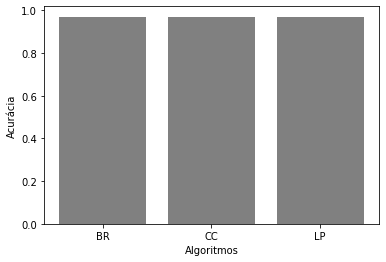

In [ ]:
# Plot das acurácias dos métodos multirrótulos.
import numpy as np
import matplotlib.pyplot as plt
# Vamos plotar um gráfico de barras

# Eixo X
algorithms = ['BR', 'CC', 'LP']
# Eixo Y
val_acc = [accuracy_score(Y_test.values, pred), accuracy_score(Y_test.values, pred2), accuracy_score(Y_test.values, pred3)]

# Barras do gráfico
plt.bar(algorithms, val_acc, color="gray")

# Nome das barras
plt.xticks(algorithms)

# Informação do eixo y
plt.ylabel('Acurácia')

# Informação do eixo X
plt.xlabel('Algoritmos')



plt.show()

Plot do gráfico de *Hamming Loss*.

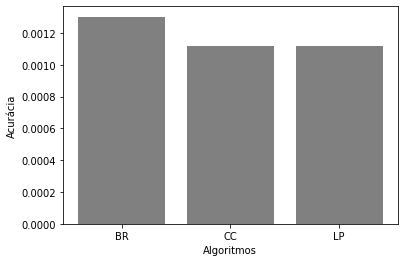

In [ ]:
# Plot dos Hamming Loss dos métodos multirrótulos.
# Vamos plotar um gráfico de barras

# Eixo X
algorithms = ['BR', 'CC', 'LP']
# Eixo Y
val_acc = [hamming_loss(Y_test.values, pred), hamming_loss(Y_test.values, pred2), hamming_loss(Y_test.values, pred3)]

# Barras do gráfico
plt.bar(algorithms, val_acc, color="gray")

# Nome das barras
plt.xticks(algorithms)

# Informação do eixo y
plt.ylabel('Acurácia')

# Informação do eixo X
plt.xlabel('Algoritmos')

plt.show()

Método vencedor é ? 

**TERMINEM DE DESCOBRIR AE QM É O MELHOR MÉTODO E ARRUMEM O GRÁFICO DE ACURÁCIA, SE VCS ACHAREM Q TEM Q ARRUMAR**

## Conclusão

Tem conclusão?